## Contraceptive Exploratory Data Analysis
Written by: Yong-Chan Shin

SID: 25421882

In [123]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import tree
from sklearn import ensemble
from sklearn.feature_selection import chi2, SelectPercentile, SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [124]:
df = pd.read_csv("contraceptive/contraceptive_for_students.csv")
df.head()

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


The dataset has two numeric features, "wife_age" and "num_child" and the rest of the features are categorical; particularly "wife_religion", "wife_work", and "media_exposure" are binary features.

## Finding Features Correlated to the Contraceptive method

In [125]:
#la_enc=LabelEncoder(categories='auto')
x=df.loc[:,df.columns!='contraceptive']
y=df[['contraceptive']]
oh_enc = OneHotEncoder(categories='auto')
x_raw=["wife_age","num_child","wife_religion","wife_work","media_exposure"]
x_ohe=x.drop(x_raw,axis=1)
x_new=oh_enc.fit_transform(x_ohe).todense()
x_new=pd.concat([x[x_raw],pd.DataFrame(data=x_new,columns=oh_enc.get_feature_names(x_ohe.columns))],axis=1)
df_new=pd.concat([x_new,y],axis=1)
y=y.values.ravel()
print(df_new.columns)

Index(['wife_age', 'num_child', 'wife_religion', 'wife_work', 'media_exposure',
       'wife_education_1', 'wife_education_2', 'wife_education_3',
       'wife_education_4', 'husband_education_1', 'husband_education_2',
       'husband_education_3', 'husband_education_4', 'husband_occupation_1',
       'husband_occupation_2', 'husband_occupation_3', 'husband_occupation_4',
       'standard_living_1', 'standard_living_2', 'standard_living_3',
       'standard_living_4', 'contraceptive'],
      dtype='object')


Since "wife_education","husband_education","husband_occupation", and "standard_living" are categorical variables with integer values from 1 to 4, one-hot encoding refined these features to 16 different binary categories, and rest of the analysis will use this encoded dataset.

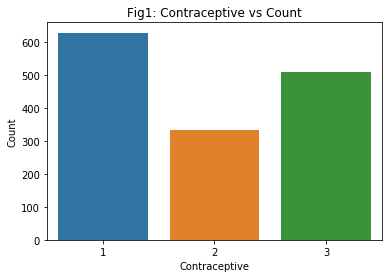

In [126]:
sns.countplot(x="contraceptive",data=df_new)
plt.xlabel("Contraceptive")
plt.ylabel("Count")
plt.title("Fig1: Contraceptive vs Count")
plt.show()

A large portion of the samples do not use any contraceptive method, short-term contraceptive method follows the next, and long-term method is used the least.

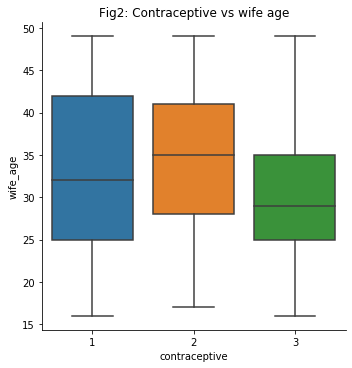

In [127]:
sns.catplot(x="contraceptive",y="wife_age",data=df_new,kind="box")
plt.title("Fig2: Contraceptive vs wife age")
plt.show()

The ages of wives who use long-term contraceptive are concentrated on large values while those using short-term contraceptive are concentrated on small values. However, no-use samples' interquartile range contains the both ranges.

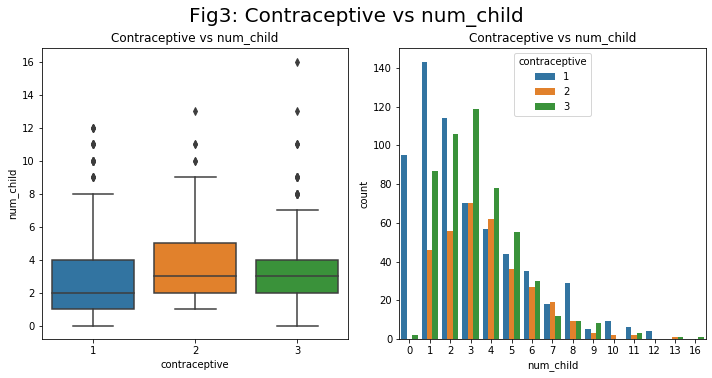

In [128]:
fig, axs = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle("Fig3: Contraceptive vs num_child",fontsize=20,y=1.04)
sns.boxplot(x="contraceptive",y="num_child",data=df_new,ax=axs[0])
axs[0].set_xlabel("contraceptive")
axs[0].set_ylabel("num_child")
axs[0].set_title("Contraceptive vs num_child")
sns.countplot(x="num_child",hue="contraceptive",data=df_new,ax=axs[1])
axs[1].set_xlabel("num_child")
axs[1].set_ylabel("count")
axs[1].set_title("Contraceptive vs num_child")
plt.tight_layout()
plt.show()

The distributions of the number of children of no-use, is concentrated on smaller values, while the 25th percentiles of the samples using any type of contraceptive are the same with the median of the no-use samples. 

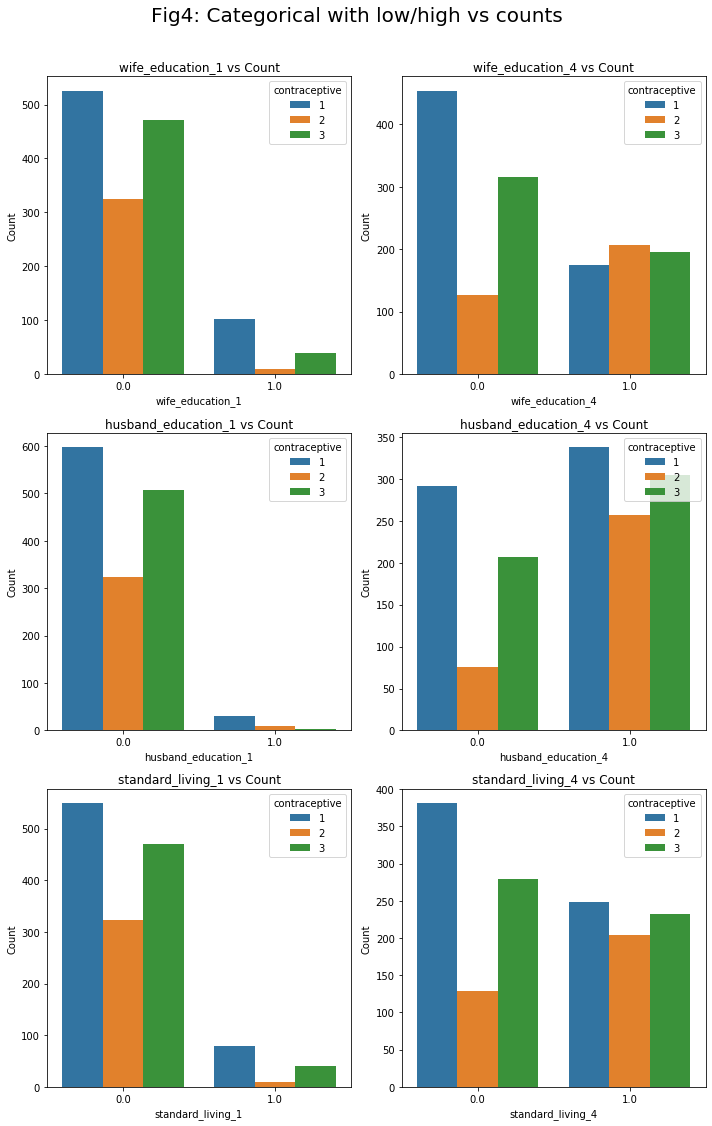

In [129]:
columns_binary=["wife_education_1","wife_education_4",
                "husband_education_1","husband_education_4",
                "standard_living_1","standard_living_4"]
fig, axs = plt.subplots(3, 2,figsize=(10,15))
fig.suptitle("Fig4: Categorical with low/high vs counts",fontsize=20,y=1.04)
r=0
c=0
for col in columns_binary:
    sns.countplot(x=col,hue="contraceptive",data=df_new,ax=axs[r,c])
    axs[r,c].set_xlabel(col)
    axs[r,c].set_ylabel("Count")
    axs[r,c].set_title(col+" vs Count")
    if c==1:
        r+=1
        c=0
    else:
        c+=1
plt.tight_layout()
plt.show()

While education level 1 of wife is dominated by no-use of contraceptive, education level 4 of wife has a very high contraceptive method usage, and especially long-term contraceptive has the largest count. Husband education level 4 and standard living level 4 have the same tendency that both the absolute number and portion of both contraceptive methods evidently increased from level 1. 

In [130]:
#PCA is not fully applicable as most of the features are not continuous variables
def score(x,y):
    RF=ensemble.RandomForestClassifier(n_estimators=25).fit(x,y)
    DT=tree.DecisionTreeClassifier().fit(x,y)
    LR=LogisticRegression(max_iter=1000,solver="liblinear",multi_class="ovr",C=1).fit(x,y) #or lbfgs
    SG=SGDClassifier(alpha=0.1).fit(x,y)
    KN=KNeighborsClassifier(n_neighbors=25).fit(x,y)
    
    models=[RF,DT,LR,SG,KN]
    model_names=["RF","DT","LR","SG","KN"]
    idx=0
    scores=np.empty([2,len(model_names)])
    for model in models:
        tscore=round(model.score(x,y),3)
        cv_score=round(np.mean(cross_val_score(model,x,y,cv=5)),3)
        cv_error=round(np.mean(cross_val_score(model,x,y,cv=5,scoring='neg_mean_squared_error')),3)
        print(model_names[idx]+"| tscore:"+str(tscore)+" vs cv_score:"+str(cv_score)+" vs cv_neg_mse:"+str(cv_error))
        scores[0][idx]=tscore
        scores[1][idx]=cv_score
        idx+=1
    scores=pd.DataFrame(scores,columns=model_names).set_index(pd.Index(["tscore","cv_score"]))
    return scores

columns_selected=["wife_age","num_child","wife_education_1","wife_education_4",
"husband_education_1","husband_education_4","standard_living_1","standard_living_4"]

print("Result w/o feature selection")
s1=score(x_new,y)
print("\nResult w/ my feature selection")
s2=score(x_new[columns_selected],y)
print("\nResult w/ SelectKBest feature selection")
s3=score(SelectKBest(chi2,k=8).fit_transform(x_new,y),y)

Result w/o feature selection
RF| tscore:0.95 vs cv_score:0.512 vs cv_neg_mse:-1.185
DT| tscore:0.955 vs cv_score:0.482 vs cv_neg_mse:-1.199
LR| tscore:0.528 vs cv_score:0.515 vs cv_neg_mse:-1.231
SG| tscore:0.474 vs cv_score:0.469 vs cv_neg_mse:-1.364
KN| tscore:0.591 vs cv_score:0.557 vs cv_neg_mse:-1.037

Result w/ my feature selection
RF| tscore:0.81 vs cv_score:0.5 vs cv_neg_mse:-1.203
DT| tscore:0.812 vs cv_score:0.463 vs cv_neg_mse:-1.253
LR| tscore:0.525 vs cv_score:0.521 vs cv_neg_mse:-1.259
SG| tscore:0.434 vs cv_score:0.466 vs cv_neg_mse:-1.369
KN| tscore:0.593 vs cv_score:0.542 vs cv_neg_mse:-1.09

Result w/ SelectKBest feature selection
RF| tscore:0.815 vs cv_score:0.533 vs cv_neg_mse:-1.075
DT| tscore:0.819 vs cv_score:0.512 vs cv_neg_mse:-1.13
LR| tscore:0.513 vs cv_score:0.511 vs cv_neg_mse:-1.24
SG| tscore:0.484 vs cv_score:0.5 vs cv_neg_mse:-1.459
KN| tscore:0.598 vs cv_score:0.552 vs cv_neg_mse:-1.039


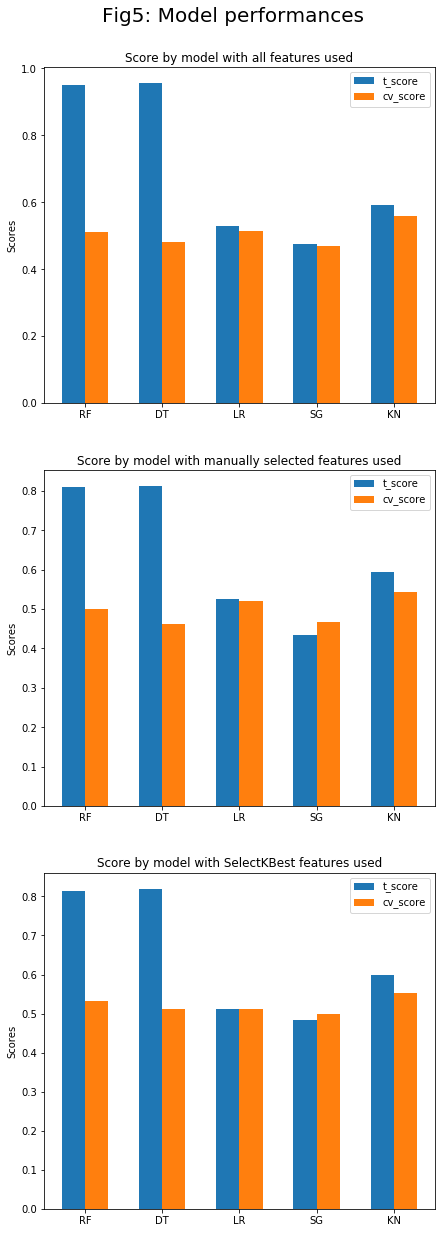

In [131]:
def plot_scores(s1,s2,s3,fig_num):
    fig, axs = plt.subplots(3, 1,figsize=(7,21))
    fig.suptitle("Fig"+str(fig_num)+": Model performances",fontsize=20,y=0.92)
    label_loc=np.arange(len(s1.columns))
    width=0.3
    rects_t0=axs[0].bar(label_loc-width/2,s1.iloc[0,:],width,label="t_score")
    rects_cv0=axs[0].bar(label_loc+width/2,s1.iloc[1,:],width,label="cv_score")
    axs[0].set_ylabel("Scores")
    axs[0].set_title("Score by model with all features used")
    axs[0].set_xticks(label_loc)
    axs[0].set_xticklabels(s1.columns)
    axs[0].legend()
    rects_t1=axs[1].bar(label_loc-width/2,s2.iloc[0,:],width,label="t_score")
    rects_cv1=axs[1].bar(label_loc+width/2,s2.iloc[1,:],width,label="cv_score")
    axs[1].set_ylabel("Scores")
    axs[1].set_title("Score by model with manually selected features used")
    axs[1].set_xticks(label_loc)
    axs[1].set_xticklabels(s1.columns)
    axs[1].legend()
    rects_t2=axs[2].bar(label_loc-width/2,s3.iloc[0,:],width,label="t_score")
    rects_cv2=axs[2].bar(label_loc+width/2,s3.iloc[1,:],width,label="cv_score")
    axs[2].set_ylabel("Scores")
    axs[2].set_title("Score by model with SelectKBest features used")
    axs[2].set_xticks(label_loc)
    axs[2].set_xticklabels(s1.columns)
    axs[2].legend()
    plt.plot()
plot_scores(s1,s2,s3,5)

The random forest and decision tree have very high training scores, but the cross validation scores were around 50% accuracy. Logistic regression, stochastic gradient descent, and k-nearest neighbors are not overfitted like the previous two models, but the cross validation scores are still around 50%. Particularly k-nearest neighbors work the best with cross validation score 55%.

## Finding Features Correlated to the Number of Children

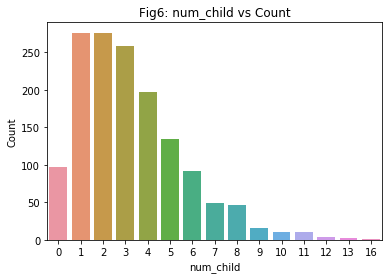

In [132]:
sns.countplot(x="num_child",data=df_new)
plt.xlabel("num_child")
plt.ylabel("Count")
plt.title("Fig6: num_child vs Count")
plt.show()

There are about 100 of "num_child" values of zero, more than 250 of samples have one child, and the rest are decreasing as the number of children increases. 

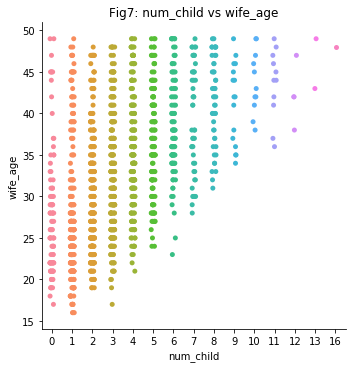

In [133]:
sns.catplot(x="num_child",y="wife_age",data=df_new)
plt.xlabel("num_child")
plt.ylabel("wife_age")
plt.title("Fig7: num_child vs wife_age")
plt.show()

The smaller the "wife_age" is, the fewer the "num_child" is, but there are still a lot of samples with high "wife_age" values but have very few "num_child" value.

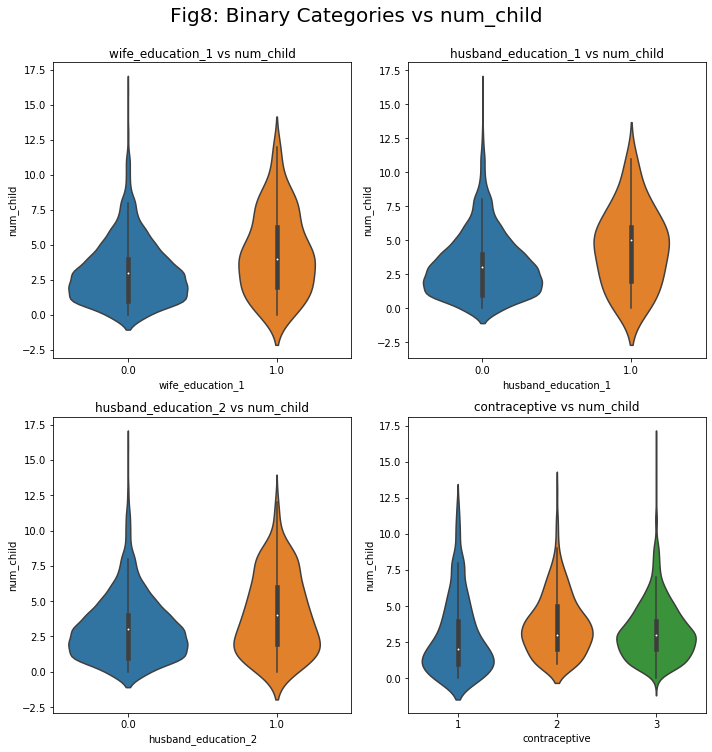

In [134]:
fig2, axs2 = plt.subplots(2, 2,figsize=(10,10))
fig2.suptitle("Fig8: Binary Categories vs num_child",fontsize=20,y=1.04)
columns_selected=["wife_education_1","husband_education_1","husband_education_2","contraceptive"]
r=0
c=0
for col in columns_selected:
    sns.violinplot(x=col,y="num_child",data=df_new,ax=axs2[r,c])
    axs2[r,c].set_xlabel(col)
    axs2[r,c].set_ylabel("num_child")
    axs2[r,c].set_title(col+" vs num_child")
    if c==1:
        r+=1
        c=0
    else:
        c+=1
plt.tight_layout()
plt.show()

There are four categorical binary features "wife_education_1", "husband_education_1", "husband_education_2", and "contraceptive" which have different "num_child" distributions by its binary values.

In [135]:
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
def score2(x,y):
    RF=ensemble.RandomForestClassifier(n_estimators=15).fit(x,y)
    DT=tree.DecisionTreeClassifier().fit(x,y)
    LR=LogisticRegression(max_iter=1000,solver="liblinear",multi_class="ovr",C=20).fit(x,y) #or lbfgs
    SG=SGDClassifier(alpha=0.001).fit(x,y)
    KN=KNeighborsClassifier(n_neighbors=25).fit(x,y)
    LS=Lasso(alpha=0.01).fit(x,y)
    LN=LinearRegression().fit(x,y)
    
    models=[RF,DT,LR,SG,KN,LS,LN]
    model_names=["RF","DT","LR","SG","KN","LS","LN"]
    idx=0
    scores=np.empty([2,len(model_names)])
    for model in models:
        tscore=round(model.score(x,y),3)
        cv_score=round(np.mean(cross_val_score(model,x,y,cv=5)),3)
        cv_error=round(np.mean(cross_val_score(model,x,y,cv=5,scoring='neg_mean_squared_error')),3)
        print(model_names[idx]+"| tscore:"+str(tscore)+" vs cv_score:"+str(cv_score)+" vs cv_neg_mse:"+str(cv_error))
        scores[0][idx]=tscore
        scores[1][idx]=cv_score
        idx+=1
    scores=pd.DataFrame(scores,columns=model_names).set_index(pd.Index(["tscore","cv_score"]))
    return scores

columns_selected=["wife_age","wife_education_1","husband_education_1","husband_education_2","contraceptive"]
df_new=df_new.groupby("num_child").filter(lambda x: len(x)>=5)
x_2=df_new.drop(["num_child"],axis=1)
y_2=df_new["num_child"].values.ravel()
print("Result w/o feature selection")
s21=score2(x_2,y_2)
print("\nResult w/ my feature selection")
s22=score2(x_2[columns_selected],y_2)
print("\nResult w/ SelectKBest feature selection")
s23=score2(SelectKBest(chi2,k=8).fit_transform(x_2,y_2),y_2)

Result w/o feature selection
RF| tscore:0.91 vs cv_score:0.232 vs cv_neg_mse:-5.839
DT| tscore:0.921 vs cv_score:0.216 vs cv_neg_mse:-6.447
LR| tscore:0.308 vs cv_score:0.241 vs cv_neg_mse:-5.297
SG| tscore:0.306 vs cv_score:0.231 vs cv_neg_mse:-8.216
KN| tscore:0.347 vs cv_score:0.286 vs cv_neg_mse:-4.75
LS| tscore:0.395 vs cv_score:0.372 vs cv_neg_mse:-3.218
LN| tscore:0.397 vs cv_score:0.369 vs cv_neg_mse:-3.234

Result w/ my feature selection
RF| tscore:0.445 vs cv_score:0.254 vs cv_neg_mse:-6.17
DT| tscore:0.447 vs cv_score:0.248 vs cv_neg_mse:-6.216
LR| tscore:0.297 vs cv_score:0.265 vs cv_neg_mse:-4.769
SG| tscore:0.235 vs cv_score:0.172 vs cv_neg_mse:-7.853
KN| tscore:0.344 vs cv_score:0.264 vs cv_neg_mse:-5.319
LS| tscore:0.34 vs cv_score:0.33 vs cv_neg_mse:-3.427
LN| tscore:0.341 vs cv_score:0.331 vs cv_neg_mse:-3.422

Result w/ SelectKBest feature selection
RF| tscore:0.573 vs cv_score:0.252 vs cv_neg_mse:-6.141
DT| tscore:0.576 vs cv_score:0.238 vs cv_neg_mse:-6.213
LR| tsc

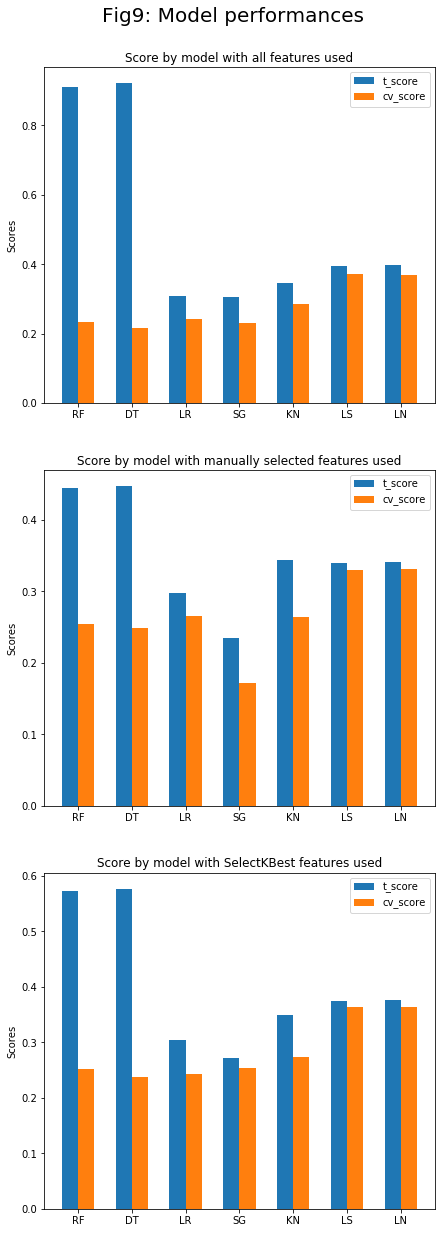

In [136]:
plot_scores(s21,s22,s23,9)

Random forest and decision tree are overfitting as the training score is very high while the cross validation score is very low. Logistic regression and k-nearest neighbors did not perform well this time as the target variable is actually not a categorical variable. In contrast, LASSO and linear regression worked the best and the scores are very close as regularization parameter of LASSO is set to be very small. 